In [ ]:
%%capture
%pip install torchvision
%pip install torchsummary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Deep_Learning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Deep_Learning


In [ ]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import itertools
import random
import matplotlib.pyplot as plt
import os


from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from torch.autograd import Variable
from torchvision import datasets, transforms
from itertools import zip_longest
from collections import deque

In [ ]:
torchvision.__version__

'0.18.0+cu121'

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 20 19:23:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Load SVHN datasets


In [ ]:
#model params
params = {
    'batch_size':32,
    'mul': 30,
    'num_classes':10,
    'channels':3,
    'img_dim':32,
    'device':torch.device('cuda') if torch.cuda.is_available() else 'cpu',
    'fliplr':True,
    'num_epochs':50,
    'decay_epoch':50,
    'lr':0.00002,    #learning rate for generator
    'beta1':0.5 ,    #beta1 for Adam optimizer
    'beta2':0.999 ,  #beta2 for Adam optimizer
    'lambdaA':10 ,   #lambdaA for cycle loss
    'lambdaB':10  ,  #lambdaB for cycle loss
}


In [ ]:
# Function to load and preprocess datasets
def load_dataset(dataset_cls, split, root, download, normalize=False, subset_size=None, batch_size=params['batch_size']):
    if dataset_cls == datasets.MNIST:
        dataset = dataset_cls(root=root, train=(split=='train'), download=download, transform=transforms.ToTensor())
    else:
        dataset = dataset_cls(root=root, split=split, download=download, transform=transforms.ToTensor())

    if normalize:
        # mean, std = compute_mean_and_std(dataset)

        if dataset_cls == datasets.MNIST:

            print(f"Dataset is MNIST: {dataset_cls}")
            transform = transforms.Compose([
                transforms.Resize(( params['img_dim'],params['img_dim']) ),
                transforms.Grayscale(params['channels']),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*params['channels'], std=[0.5]*params['channels'])
            ])\

        else:
            print(f"Dataset is SVHN: {dataset_cls}")
            transform = transforms.Compose([
                transforms.Resize(( params['img_dim'],params['img_dim'] )),
                transforms.Grayscale(params['channels']),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*params['channels'], std=[0.5]*params['channels'])
            ])

        # Apply the computed normalization
        dataset.transform = transform

    if subset_size:
        indices = np.random.choice(len(dataset), subset_size, replace=False)
        print(dataset.transform)
        dataset = Subset(dataset, indices)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True if split == 'train' else False, num_workers=1)
    return loader

# Load MNIST datasets
mnist_trainloader = load_dataset(datasets.MNIST, 'train', './data/', True, normalize=True,subset_size=params['batch_size']*params['mul'] )
mnist_testloader = load_dataset(datasets.MNIST, 'test', './data/', True, normalize=True)

# Load SVHN datasets
svhn_trainloader = load_dataset(datasets.SVHN, 'train', './data/', True, normalize=True,subset_size=params['batch_size']*params['mul'])
svhn_testloader = load_dataset(datasets.SVHN, 'test', './data/', True, normalize=True)

# Optionally, load the extra SVHN dataset if needed
# svhn_extraloader = load_dataset(datasets.SVHN, 'extra', './data/', True, normalize=True, subset_size=20000)

# Verify the sizes of the datasets
print(f'MNIST train subset size: {len(mnist_trainloader.dataset)}')
# print(f'SVHN train subset size: {len(svhn_trainloader.dataset)}')
# print(f'SVHN extra size: {len(svhn_extraloader.dataset)}')



Dataset is MNIST: <class 'torchvision.datasets.mnist.MNIST'>
Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
Dataset is MNIST: <class 'torchvision.datasets.mnist.MNIST'>
Using downloaded and verified file: ./data/train_32x32.mat
Dataset is SVHN: <class 'torchvision.datasets.svhn.SVHN'>
Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
Using downloaded and verified file: ./data/test_32x32.mat
Dataset is SVHN: <class 'torchvision.datasets.svhn.SVHN'>
MNIST train subset size: 32000


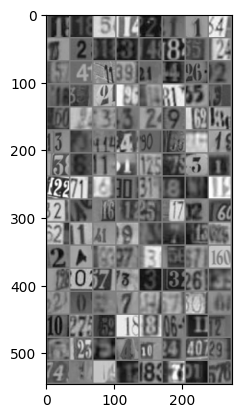

In [ ]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(svhn_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join(f'{dataiter.target[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
from torch.utils.data import DataLoader, random_split
#### create val set
val_size = 10000
train_size = len(svhn_trainloader.dataset) - val_size
svhn_val, svhn_train = random_split(svhn_trainloader.dataset, [val_size, train_size]) # Split svhn_trainloader.dataset


val_loader = DataLoader(svhn_val, batch_size=params['batch_size'], shuffle=False)
test_loader = DataLoader(svhn_train, batch_size=params['batch_size'], shuffle=False)

### Training VGG-16 on SVHN

In [ ]:
# Define the VGG-16 architecture without pretrained weights
class VGG16Custom(nn.Module):
    def __init__(self, num_classes=params['num_classes']):
        super(VGG16Custom, self).__init__()
        # Load the VGG-16 model
        self.features = models.vgg16(weights=None).features
        # Modify the first convolutional layer to accept 1-channel input
        self.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        # Add a custom classifier (fully connected layers)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
vgg16 = VGG16Custom().to(params['device'])
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=params['lr'])


# Training loop with validation
for epoch in range(params['num_epochs']):
    vgg16.train()
    running_loss = 0.0
    for images, labels in svhn_trainloader:
        images, labels = images.to(params['device']), labels.to(params['device'])

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vgg16(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    print(f'Epoch [{epoch + 1}/{params["num_epochs"]}], Loss: {running_loss / len(svhn_trainloader):.4f}')

    # Validation step
    vgg16.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(params['device']), labels.to(params['device'])
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Evaluate the model on the test set
vgg16.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(params['device']), labels.to(params['device'])
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/10], Loss: 1.7856
Validation Loss: 1.0908, Validation Accuracy: 62.22%
Epoch [2/10], Loss: 0.6896
Validation Loss: 0.4051, Validation Accuracy: 88.15%
Epoch [3/10], Loss: 0.3962
Validation Loss: 0.2901, Validation Accuracy: 91.41%
Epoch [4/10], Loss: 0.2931
Validation Loss: 0.2163, Validation Accuracy: 94.06%
Epoch [5/10], Loss: 0.2300
Validation Loss: 0.1360, Validation Accuracy: 96.29%
Epoch [6/10], Loss: 0.1863
Validation Loss: 0.1308, Validation Accuracy: 96.28%
Epoch [7/10], Loss: 0.1425
Validation Loss: 0.0994, Validation Accuracy: 97.26%
Epoch [8/10], Loss: 0.1284
Validation Loss: 0.0906, Validation Accuracy: 97.33%
Epoch [9/10], Loss: 0.1053
Validation Loss: 0.0810, Validation Accuracy: 97.77%
Epoch [10/10], Loss: 0.0911
Validation Loss: 0.0624, Validation Accuracy: 98.27%
Test Loss: 0.0688, Test Accuracy: 98.16%


#### Save the SVHN based trained VGG-16

In [ ]:
# # Save the trained model
torch.save(vgg16.state_dict(), 'model_checkpoints/3channeled_vgg16_svhn.pth')

In [ ]:
### UDA basline model(SVHN->MNIST)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Use a dummy input to determine the size of the flattened features
        dummy_input = torch.randn(1, 3, 32, 32)  # Change the input size if necessary
        dummy_output = self.feature_extractor(dummy_input)
        flattened_size = dummy_output.view(-1).size(0)

        # Now use the calculated flattened size for the classifier
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        return output

class DomainDiscriminator(nn.Module):
    def __init__(self, feature_size):
        super(DomainDiscriminator, self).__init__()
        self.domain_classifier = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, 2)  # Two classes: source and target
        )

    def forward(self, x):
        output = self.domain_classifier(x)
        return output

# Initialize the model and print the flattened feature size
model = SimpleCNN()
print(model)


SimpleCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10

In [ ]:
feature_extractor = SimpleCNN().to(params['device'])
flattened_size = feature_extractor.classifier[0].in_features  # Get the input feature size of the first Linear layer
domain_discriminator = DomainDiscriminator(flattened_size).to(params['device'])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(feature_extractor.parameters()) + list(domain_discriminator.parameters()), lr=0.00001)


In [ ]:
def train(model, domain_model, source_loader, target_loader, criterion, optimizer, num_epochs=20):
    model.train()
    domain_model.train()

    for epoch in range(num_epochs):
        for (source_data, source_labels), (target_data, _) in zip(source_loader, target_loader):
            source_data, source_labels = source_data.to(params['device']), source_labels.to(params['device'])
            target_data = target_data.to(params['device'])

            # Train feature extractor and classifier on source data
            optimizer.zero_grad()
            source_features = model.feature_extractor(source_data)
            source_output = model.classifier(source_features.view(source_features.size(0), -1))
            source_loss = criterion(source_output, source_labels)
            source_loss.backward()
            optimizer.step()

            # Train domain discriminator on source and target data
            optimizer.zero_grad()
            domain_labels = torch.cat((torch.zeros(source_data.size(0)), torch.ones(target_data.size(0)))).long().to(params['device'])
            combined_data = torch.cat((source_data, target_data))
            combined_features = model.feature_extractor(combined_data)
            domain_output = domain_model(combined_features.view(combined_features.size(0), -1))
            domain_loss = criterion(domain_output, domain_labels)
            domain_loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Source Loss: {source_loss.item():.4f}, Domain Loss: {domain_loss.item():.4f}')

# Train the model
train(feature_extractor, domain_discriminator, svhn_trainloader, mnist_trainloader, criterion, optimizer)


Epoch [1/20], Source Loss: 1.9297, Domain Loss: 0.0074
Epoch [2/20], Source Loss: 1.3940, Domain Loss: 0.0031
Epoch [3/20], Source Loss: 1.0423, Domain Loss: 0.0023
Epoch [4/20], Source Loss: 0.8552, Domain Loss: 0.0039
Epoch [5/20], Source Loss: 0.7749, Domain Loss: 0.0007
Epoch [6/20], Source Loss: 0.7019, Domain Loss: 0.0008
Epoch [7/20], Source Loss: 0.7544, Domain Loss: 0.0004
Epoch [8/20], Source Loss: 0.5300, Domain Loss: 0.0003
Epoch [9/20], Source Loss: 0.4798, Domain Loss: 0.0004
Epoch [10/20], Source Loss: 0.6263, Domain Loss: 0.0002
Epoch [11/20], Source Loss: 0.6212, Domain Loss: 0.0001
Epoch [12/20], Source Loss: 0.4672, Domain Loss: 0.0002
Epoch [13/20], Source Loss: 0.4162, Domain Loss: 0.0001
Epoch [14/20], Source Loss: 0.3256, Domain Loss: 0.0001
Epoch [15/20], Source Loss: 0.4778, Domain Loss: 0.0000
Epoch [16/20], Source Loss: 0.3378, Domain Loss: 0.0000
Epoch [17/20], Source Loss: 0.3844, Domain Loss: 0.0002
Epoch [18/20], Source Loss: 0.5090, Domain Loss: 0.0001
E

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(params['device']), labels.to(params['device'])
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

source_accuracy = evaluate(feature_extractor, svhn_testloader, params['device'])
target_accuracy = evaluate(feature_extractor, mnist_testloader, params['device'])
print(f'Source (SVHN) Accuracy: {source_accuracy:.2f}%')
print(f'Target (MNIST) Accuracy: {target_accuracy:.2f}%')


Source (SVHN) Accuracy: 85.10%
Target (MNIST) Accuracy: 55.01%
